# CNN for Shape Dimensions

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms 
from torch.utils.data import DataLoader

from data_load import ShapeDimensionDataset

from sections import VERTEX_FUNCTIONS

## Transformations

In [20]:
## Define Transforms

full_transform = transforms.Compose([
    # these operate on PIL image
    transforms.Resize((100, 100), interpolation=0),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # the fill thing needs to be 255 (white); we're still in uint8 mode
    transforms.RandomRotation((-45,45), expand=False, fill=255),
    # Normalise wants a tensor as input, so ToTensor has to run first
    transforms.ToTensor(), 
    transforms.Normalize(0, 1), 
])

flip_transform = transforms.Compose([
    # these operate on PIL image
    transforms.Resize((100, 100), interpolation=0),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # Normalise wants a tensor as input, so ToTensor has to run first
    transforms.ToTensor(), 
    transforms.Normalize(0, 1), 
])

no_transform = transforms.Compose([
    # Normalise wants a tensor as input, so ToTensor has to run first
    transforms.Resize((100, 100), interpolation=0),
    transforms.ToTensor(), 
    transforms.Normalize(0, 1), 
])

## Datasets and Dataloaders

omit test for the time being ...

In [3]:
shape_func, shape_params = VERTEX_FUNCTIONS['c2']
target_cols = [p + "_scaled" for p in shape_params]

datasets = {
    'train': ShapeDimensionDataset("dataset/C2_train.csv", 
                                   "dataset/train/C2/",
                                   transform=no_transform, 
                                   target_cols=target_cols
                                  ),
    'val': ShapeDimensionDataset("dataset/C2_val.csv", 
                                   "dataset/val/C2/",
                                   transform=no_transform,
                                   target_cols=target_cols
                                ),    
}

In [4]:
BATCH_SIZE = 32

dataloaders = {'train': DataLoader(datasets['train'], 
                                   batch_size=BATCH_SIZE,
                                   shuffle=True, 
                                   num_workers=6),
               'val': DataLoader(datasets['val'], 
                                 batch_size=BATCH_SIZE,
                                 shuffle=False, 
                                 num_workers=6),                                       
    }


## Show something

Convert PIL grayscale image (type=L) to np array (axes are still flipped):

`img = np.frombuffer(img_.tobytes(), dtype=np.uint8).reshape(224,224)`

Convert torch.Tensor to np array:



pixel value range: 0.0 1.0
shape: (100, 100)
dtype: float32
[[0.25991578]
 [0.31267151]
 [0.50710719]
 [0.39772495]
 [0.45535454]
 [0.55873339]]


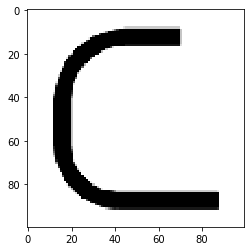

In [5]:


ds = datasets['train']

img_, y = ds[40]  
# TODO: how to rotate ???
img = img_[0].numpy() # shape(1,224,224) -> shape(224,224)
img = img.squeeze()
print("pixel value range:", np.min(img), np.max(img))
# TODO: these are grayscale (B/W) pictures. One depth dimension is enough.
print("shape:", img.shape)
print("dtype:", img.dtype)
print(y)
plt.imshow(img, cmap='gray');



## Training function

In [6]:
# TODO: make nicer progress reporting using tqdm
# for i, batch in enumerate(tqdm(dataloader))

def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=1):
    """Train a model. After training, the model weights are set to those that resulted 
    in the lowest validation loss during training.
    
    Parameters:
    - model: a model instance
    - dataloaders: a dictionary. Must have keys "train" and "val", and dataloaders as values
    - criterion: a loss function
    - optimizer: an optimizer instance
    - scheduler: a method from torch.optim.lr_scheduler
    - num_epochs: number of epochs to train (default 1)
    
    Returns:
    - history: dict with training/validation loss history
    """

    best_model_wts = copy.deepcopy(model.state_dict())

    # set initial loss to infinity
    best_loss = np.inf 

    dataset_sizes = {k: len(loader.dataset) for k, loader in dataloaders.items()}

    # initialise 
    history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data batches
            dataloader = dataloaders[phase]
            for batch_i, data in enumerate(dataloader):

                # get the input images and the shape parameters
                images, targets = data

                # flatten pts
                targets = targets.view(targets.size(0), -1)

                # convert variables to floats for regression loss
                #images = images.type(torch.FloatTensor)
                targets = targets.type(torch.FloatTensor)

                # zero the parameter (weight) gradients
                optimizer.zero_grad()                
                
                # forward pass to get outputs
                output = model.forward(images)

                # calculate the loss between predicted and target keypoints
                loss = criterion(output, targets)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # Statistics. Loss function returns mean loss over images; multiply by size of current batch
                running_loss += loss.item() * images.size(0)

            # learning rate scheduler
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            # epoch finished
            epoch_loss = running_loss / dataset_sizes[phase]
            history[phase].append(epoch_loss)
            print('{} Loss: {:.6f}'.format(phase, epoch_loss))
          
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    # final message
    print('\nBest val loss: {:6f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return history


## Define a Model

In [7]:

def conv_dims(input_size, k, s, p):
    """Return output size for a 2D convolution kernel (square input, 
    square kernel). See https://arxiv.org/pdf/1603.07285v2.pdf, relationship 6

    Parameters
    ----------
    input_size : int
        size (width) of input feature
    k : int
        convolution kernel size
    s : int
        convolution stride
    p : int 
        zero padding

    Returns
    -------
    output_size : int
        size (width) of output feature
    
    """
    return (input_size + 2*p - k)//s + 1



def pool_dims(input_size, k, s):
    """Return output size for a 2D convolution kernel (square input, 
    square kernel). See https://arxiv.org/pdf/1603.07285v2.pdf, relationship 7

    Parameters
    ----------
    input_size : int
        size (width) of input feature
    k : int
        pooling kernel size
    s : int
        pooling stride

    Returns
    -------
    output_size : int
        size (width) of output feature
    
    """
    return (input_size - k)//s + 1

In [8]:
IMAGE_SIZE = 100
OUTPUT_SIZE = 6

class Net1(nn.Module):
    
    def __init__(self):
        super(Net1, self).__init__()
        
        # first convolution
        i1, m1, n1 = IMAGE_SIZE, 1, 8    # input size, num features in, num out
        k1, s1, p1 = 5, 2, 0              # kernel size, stride, padding
        o1 = conv_dims(i1, k1, s1, p1)    # output size
        # first pooling
        kp1, sp1 = 2, 2                   # kernel size, stride  
        op1 = pool_dims(o1, kp1, sp1)     # output size
        # second convolution
        i2, m2, n2 = op1, n1, 16          # input size, num features in, num out
        k2, s2, p2 = 3, 1, 0              # kernel size, stride, padding
        o2 = conv_dims(i2, k2, s2, p2)    # output size
        # second pooling
        kp2, sp2 = 2, 2                   # kernel size, stride
        op2 = pool_dims(o2, kp2, sp2)     # output size

        # fully connected layers
        self.mh0 = n2 * op2**2            # needed later - size of first linear layer
        mh1 = 1000                        # input size of second fully connected layer        
        mh2 = 50                        # input size of second fully connected layer        
        
        self.conv1 = nn.Conv2d(m1, n1, k1, stride=s1, padding=p1)
        self.conv2 = nn.Conv2d(m2, n2, k2, stride=s2, padding=p2)
        self.pool1 = nn.MaxPool2d(kp1, stride=sp1)
        self.pool2 = nn.MaxPool2d(kp2, stride=sp2)        

        self.fc1 = nn.Linear(self.mh0, mh1)
        self.fc2 = nn.Linear(mh1, mh2)
        self.fc3 = nn.Linear(mh2, OUTPUT_SIZE)
        
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, self.mh0)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
def plot_history(history, log=False):
    """history plot, return image"""
    fig, ax = plt.subplots()
    ax.plot(history['train'], "o-", label="train")
    ax.plot(history['val'], "o-", label="val")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    if log:
        ax.semilogy()
    ax.grid()
    ax.legend()

## Settings

In [10]:
lr = 0.0003

model = Net1()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
print(model)
 

Net1(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1936, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=6, bias=True)
)


In [11]:
if 1 == 0:
    hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=50)

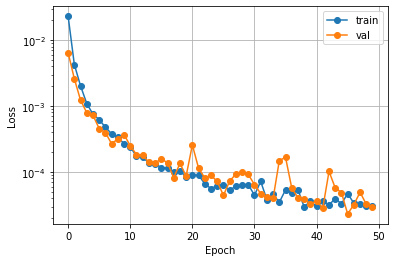

In [46]:
plot_history(hist, log=True)

Ah, great! It works!

### Save model

In [12]:
# after training, save your model parameters in the dir 'saved_models'
torch.save(model.state_dict(), "models/C2_Net1_50.pt")

# Inference

### Utilities

In [13]:
from sklearn.preprocessing import MinMaxScaler
import pickle
import pandas as pd
from sections import VERTEX_FUNCTIONS

shape_func, shape_params = VERTEX_FUNCTIONS['c2']

def imshow(tensor):
    """show first image in a tensor"""
    img = tensor[0].numpy() # shape(1,224,224) -> shape(224,224)
    img = img.squeeze()
    plt.imshow(img, cmap='gray');
    
def load_checkpoint(model, fpath):
    state_dict = torch.load(fpath, map_location='cpu')
    model.load_state_dict(state_dict)
    model.eval()

In [14]:
# instantiate model, load weights
model = Net1()
load_checkpoint(model, "models/C2_Net1_50.pt")

# scaler
with open("dataset/C2_scaler.pkl", "rb") as fp:
    scaler = pickle.load(fp)

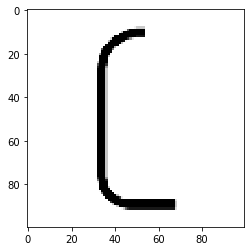

In [15]:
i = 93
area = 200

# get data point
ds = datasets['val']
image, target = ds[i]
# show image and target
imshow(image)

In [16]:
img = image.reshape(1, 1, 100, 100)
img.shape
with torch.no_grad():
    outputs = model.forward(img)
    outputs = outputs.numpy()
    
# print raw target / output
print(shape_params)

print("target (scaled): ", target.squeeze())
print("output (scaled): ", outputs) #.squeeze())

# unscale both, multiply with reference length (sqrt(A))
target_dim = np.sqrt(area) * scaler.inverse_transform(target.T)
target_dim = target_dim.squeeze()
output_dim = np.sqrt(area) * scaler.inverse_transform(outputs)
output_dim = output_dim.squeeze()
print("target (unscaled): ", target_dim)
print("output (unscaled): ", output_dim)

# generate vertices

['h', 'tw', 'ba', 'ra', 'bf', 'rf']
target (scaled):  [0.85000573 0.19437116 0.35025127 0.30133401 0.19691905 0.54281199]
output (scaled):  [[-0.07387615  0.05616268 -0.00180648  0.07755071  0.00727693 -0.12759452]]
target (unscaled):  [56.19570602  2.44329157 24.43291566  7.3298747  14.6597494   9.77316626]
output (unscaled):  [19.424664   1.9747661 12.239778   4.536706   8.71966    2.1103277]


In [17]:
# show results
df = pd.DataFrame([target_dim, output_dim], index=['true', 'predicted'], 
                  columns=shape_params)
df.round(2)

,h,tw,ba,ra,bf,rf
true,56.20,2.44,24.43,7.33,14.66,9.77
predicted,19.42,1.97,12.24,4.54,8.72,2.11


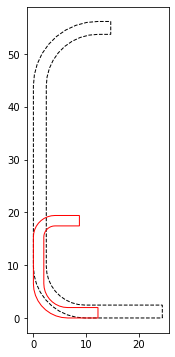

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))

# generate polygons
true_o, true_i = shape_func(*target_dim.squeeze())
pred_o, pred_i = shape_func(*output_dim.squeeze())


for outer in true_o:
    mppoly = plt.Polygon(outer, ec="k", ls='--', fill=False, linewidth=1)
    ax.add_patch(mppoly)
for inner in true_i:
    mppoly = plt.Polygon(inner, ec="k", ls='--', fill=False, linewidth=1)
    ax.add_patch(mppoly)
    
for outer in pred_o:
    mppoly = plt.Polygon(outer, ec="r", fill=False, linewidth=1)
    ax.add_patch(mppoly)
for inner in pred_i:
    mppoly = plt.Polygon(inner, ec="r", fill=False, linewidth=1)
    ax.add_patch(mppoly)

ax.autoscale(tight=False)
ax.set_aspect("equal")
#ax.axis("off");


### Evaluate: Compute IOU

In [101]:
# to be completed

### Full Loop: Input polygon vertices, create image 

In [ ]:
# to be completed